#### **TIME SERIES - FROM NEW DATASET**

- We are exploring trends in fresher hiring across years and identifying if there are any interesting things we can uncover based on gender.

In [36]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


class DataLoader:
    # Class for loading and cleaning the dataset.
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.df_unfiltered = None
        self.df = None

    def load_data(self):
        # Loads the data from a CSV file.
        self.df_unfiltered = pd.read_csv(self.file_path)
        print(f"Total number of datapoints(rows): {len(self.df_unfiltered)}")

    def clean_data(self):
        # Cleans the dataset by removing missing values.
        self.df = self.df_unfiltered.dropna(axis=0, how='any')

    def get_dataframe(self):
        # Returns the cleaned dataframe.
        return self.df

class DataTransformer:
    # Class for transforming the dataset.
    
    def __init__(self, df):
        self.df = df

    def standardize_education(self):
        # Standardizes education levels.
        self.df['Education Level'] = self.df['Education Level'].replace({
            "Bachelor's Degree": "Bachelor's",
            "Master's Degree": "Master's",
            "PhD": "phD"
        })

    def calculate_year_hired(self):
        # Calculates the year the employee was hired.
        self.df['Year Hired'] = (2022 - self.df['Years of Experience']).astype(int)

    def calculate_age_as_fresher(self):
        # Calculates the employee's age when they started as a fresher.
        self.df['Age as Fresher'] = (self.df['Age'] - self.df['Years of Experience']).astype(int)

    def map_job_titles(self, job_category_mapping, job_department_mapping):
        # Maps job titles to job categories and departments.
        self.df['Job Category'] = self.df['Job Title'].map(job_category_mapping)
        self.df['Job Department'] = self.df['Job Category'].map(job_department_mapping)

    def filter_top_departments(self, n=3):
        # Filters the dataset to include only the top N job departments.
        top_departments = self.df['Job Department'].value_counts().nlargest(n).index
        self.df = self.df[self.df['Job Department'].isin(top_departments)]

    def get_transformed_data(self):
        # Returns the transformed dataframe.
        return self.df
    
class DataAnalysis:
    # Class for performing analysis and visualizations.
    
    def __init__(self, df):
        self.df = df

    def describe_data(self):
        # Displays descriptive statistics of the dataset.
        print(self.df.describe())

    def display_unique_values(self, columns):
        # Displays unique values for the specified columns.
        for column in columns:
            print(f"Unique values in '{column}': {self.df[column].unique()}")

    def plot_value_counts(self, column):
        # Plots the value counts of a specified column.
        plt.figure(figsize=(10, 6))
        sns.countplot(y=column, data=self.df, order=self.df[column].value_counts().index)
        plt.title(f"Value Counts of {column}")
        plt.show()
        
    def plot_grouped_data(
        self, index_col, x_col, value_col, agg_func='count', 
        title='Plot', xlabel='X-Axis', ylabel='Y-Axis'
    ):
        # Reusable function to plot grouped data based on given parameters.

        # Parameters:
        # index_col (str): Column to group by (e.g., 'Job Department').
        # x_col (str): Column to plot on the X-axis (e.g., 'Year Hired').
        # value_col (str): Column whose values are aggregated (e.g., 'Age as Fresher').
        # agg_func (str): Aggregation function (e.g., 'count', 'sum', 'mean'). Default is 'count'.
        # title (str): Title of the plot.
        # xlabel (str): Label for the X-axis.
        # ylabel (str): Label for the Y-axis.
       
        grouped_data = self.df.pivot_table(
            index=index_col,
            columns=x_col,
            values=value_col,
            aggfunc=agg_func,
            fill_value=0
        )

        # Plot the graph
        plt.figure(figsize=(15, 8))
        for group in grouped_data.index:
            plt.plot(
                grouped_data.columns, 
                grouped_data.loc[group], 
                marker='o', 
                label=group
            )

        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=90)
        plt.xticks(grouped_data.columns)  # Ensure all years/columns are shown
        plt.legend(title=index_col, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid()
        plt.tight_layout()
        plt.show()
        
    def plot_for_category(
        self, category_value, category_col, x_col, group_by_cols, 
        title_prefix='Count of Events for', xlabel='Year Hired', ylabel='Count'
    ):
        # Plots a graph for a specific category value.

        # Parameters:
        # category_value (str): Specific value of the category to filter (e.g., 'Technology').
        # category_col (str): Column to filter by (e.g., 'Job Category 2').
        # x_col (str): Column to plot on the X-axis (e.g., 'Year Hired').
        # group_by_cols (list): Columns to group by (e.g., ['Year Hired', 'Gender']).
        # title_prefix (str): Prefix for the plot title.
        # xlabel (str): Label for the X-axis.
        # ylabel (str): Label for the Y-axis.
        
        # Filter the data for the given category value
        category_data = self.df[self.df[category_col] == category_value]

        # Group and aggregate the data
        grouped = category_data.groupby(group_by_cols).size().reset_index(name='Count')

        # Pivot the data to have groups (e.g., Gender) as columns
        pivoted = grouped.pivot(index=x_col, columns=group_by_cols[1], values='Count').fillna(0)

        # Plot the graph for the given category value
        pivoted.plot(kind='line', marker='o', figsize=(8, 6))

        # Set plot title and labels
        plt.title(f"{title_prefix} {category_value} by {group_by_cols[1]}")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        # Display the plot with a legend
        plt.legend(title=group_by_cols[1], bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
    def perform_chi_square_test(self, job_department_col, gender_col):
            # Step 1: Prepare the data
            # Filter the relevant job departments
            top_departments = self.df[job_department_col].value_counts().nlargest(3).index
            filtered_data = self.df[self.df[job_department_col].isin(top_departments)]

            # Create a contingency table
            contingency_table = pd.crosstab(filtered_data[job_department_col], filtered_data[gender_col])

            # Step 2: Conduct the Chi-Square Test
            chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

            # Step 3: Return the p-value and the contingency table for reference
            return p_value, contingency_table

    def confirm_hypothesis(self, job_department_col, gender_col, alpha=0.05):
        # Perform the chi-square test
        p_value, contingency_table = self.perform_chi_square_test(job_department_col, gender_col)
        
        # Print the contingency table for reference
        print("Contingency Table:")
        print(contingency_table)
        
        # Print the results
        print(f"P-Value: {p_value}")
        # Determine whether to reject the null hypothesis
        if p_value < alpha:
            print("Reject the null hypothesis: There is a significant association between Job Department and gender in hiring freshers.")
        else:
            print("Fail to reject the null hypothesis: There is no significant association between Job Department and gender in hiring freshers.")

# Loop through each unique Job Category to create separate graphs
class GenderIndustryPlotter:
    def __init__(self, dataframe):
        """Initialize with the DataFrame."""
        self.df = dataframe

    def plot_industry_data(self):
        """Loop through industries and plot gender-based moving averages."""
        for industry in self.df['Job Department'].unique():
            pivoted = self._prepare_data(industry)
            self._plot_graph(pivoted, industry)

    def _prepare_data(self, industry):
        """Prepare and pivot the data for the given industry."""
        # Filter data for the current industry
        industry_data = self.df[self.df['Job Department'] == industry]
        industry_data = industry_data[industry_data['Year Hired'] != 2022]
        # Group and count occurrences by Year Hired and Gender
        grouped = industry_data.groupby(['Year Hired', 'Gender']).size().reset_index(name='Count')
        # Pivot the data to have Gender as columns
        pivoted = grouped.pivot(index='Year Hired', columns='Gender', values='Count').fillna(0)
        return pivoted

    def _plot_graph(self, pivoted, industry):
        """Plot the graph for the given industry."""
        # Plot the moving averages
        pivoted.plot(kind='line', marker='o', figsize=(8, 6))
        # Set labels, title, and legend
        plt.xlabel('Year Hired')
        plt.ylabel('Count')
        plt.title(f'Count of Events for {industry} by Gender')
        # Adjust x-axis ticks
        plt.xticks(ticks=range(1990, 2025, 5))
        # Set legend outside the plot
        plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
        # Ensure layout fits and display the plot
        plt.tight_layout()
        plt.show()
        return
    

# Loop through each unique Job Category to create separate graphs
class MovingAveragePlotter:
    def __init__(self, dataframe):
        """Initialize with the DataFrame."""
        self.df = dataframe

    def plot_industry_data(self):
        """Loop through industries and plot gender-based moving averages."""
        for industry in self.df['Job Department'].unique():
            pivoted = self._prepare_data(industry)
            self._plot_graph(pivoted, industry)

    def _prepare_data(self, industry):
        """Prepare and pivot the data for the given industry."""
        # Filter data for the current industry
        industry_data = self.df[self.df['Job Department'] == industry]
        # Group and count occurrences by Year Hired and Gender
        grouped = industry_data.groupby(['Year Hired', 'Gender']).size().reset_index(name='Count')
        # Pivot the data to have Gender as columns
        pivoted = grouped.pivot(index='Year Hired', columns='Gender', values='Count').fillna(0)
        # Calculate 5-period simple moving averages for Female and Male
        pivoted['5-SMA F'] = pivoted['Female'].rolling(window=5).mean()
        pivoted['5-SMA M'] = pivoted['Male'].rolling(window=5).mean()
        # Drop the original Female and Male columns
        return pivoted.drop(['Female', 'Male'], axis=1)

    def _plot_graph(self, pivoted, industry):
        """Plot the graph for the given industry."""
        # Plot the moving averages
        pivoted.plot(kind='line', marker='o', figsize=(8, 6))
        # Set labels, title, and legend
        plt.xlabel('Year Hired')
        plt.ylabel('Count')
        plt.title(f'Count of Events for {industry} by Gender')
        # Adjust x-axis ticks
        plt.xticks(ticks=range(1990, 2025, 5))
        # Set legend outside the plot
        plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
        # Ensure layout fits and display the plot
        plt.tight_layout()
        plt.show()
        return
    

# Loop through each unique Job Category to create separate graphs
class LogTransformationHelper:
    def __init__(self, dataframe):
        """Initialize with the DataFrame."""
        self.df = dataframe

    def plot_industry_data(self):
        """Loop through industries and plot gender-based moving averages."""
        for industry in self.df['Job Department'].unique():
            pivoted = self._prepare_data(industry)
            self._plot_graph(pivoted, industry)

    def _prepare_data(self, industry):
        """Prepare and pivot the data for the given industry."""
        # Filter data for the current industry
        industry_data = self.df[self.df['Job Department'] == industry]
        # Group and count occurrences by Year Hired and Gender
        grouped = industry_data.groupby(['Year Hired', 'Gender']).size().reset_index(name='Count')
        # Pivot the data to have Gender as columns
        pivoted = grouped.pivot(index='Year Hired', columns='Gender', values='Count').fillna(0)
        # Calculate 5-period simple moving averages for Female and Male
        pivoted['5-SMA F'] = pivoted['Female'].rolling(window=5).mean()
        pivoted['5-SMA M'] = pivoted['Male'].rolling(window=5).mean()
        pivoted['5SMA LogValue F'] = np.log(pivoted['Female'])
        pivoted['5SMA LogValue M'] = np.log(pivoted['Male'])
        #pivoted['Differenced Log Value F'] = pivoted['5SMA LogValue F'].diff()  # First-order differencing
        #pivoted['Differenced Log Value M'] = pivoted['5SMA LogValue M'].diff()  # First-order differencing

        # Drop the original Female and Male columns
        return pivoted.drop(['Female', 'Male', '5-SMA M', '5-SMA F'], axis=1)

    def _plot_graph(self, pivoted, industry):
        """Plot the graph for the given industry."""
        # Plot the moving averages
        pivoted.plot(kind='line', marker='o', figsize=(8, 6))
        # Set labels, title, and legend
        plt.xlabel('Year Hired')
        plt.ylabel('Count')
        plt.title(f'Count of Events for {industry} by Gender')
        # Adjust x-axis ticks
        plt.xticks(ticks=range(1990, 2025, 5))
        # Set legend outside the plot
        plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
        # Ensure layout fits and display the plot
        plt.tight_layout()
        plt.show()
        return
    
    




> #### We are mapping the jobs to respective categories and department for better understanding of the data.

In [37]:
job_category_mapping = {
    'Software Engineer': 'Engineering & Software Development',
    'Data Analyst': 'Data Science, Analytics, and BI',
    'Senior Manager': 'Management',
    'Sales Associate': 'Sales & Business Development',
    'Director': 'Management',
    'Marketing Analyst': 'Marketing & Sales',
    'Product Manager': 'Product Management',
    'Sales Manager': 'Sales & Business Development',
    'Marketing Coordinator': 'Marketing & Sales',
    'Senior Scientist': 'Research & Development',
    'Software Developer': 'Engineering & Software Development',
    'HR Manager': 'Human Resources',
    'Financial Analyst': 'Finance & Accounting',
    'Project Manager': 'Project Management',
    'Customer Service Rep': 'Customer Service',
    'Operations Manager': 'Operations',
    'Marketing Manager': 'Marketing & Sales',
    'Senior Engineer': 'Engineering & Software Development',
    'Data Entry Clerk': 'Administrative Support',
    'Sales Director': 'Sales & Business Development',
    'Business Analyst': 'Business Analysis',
    'VP of Operations': 'Management',
    'IT Support': 'Information Technology',
    'Recruiter': 'Human Resources',
    'Financial Manager': 'Finance & Accounting',
    'Social Media Specialist': 'Marketing & Sales',
    'Software Manager': 'Engineering & Software Development',
    'Junior Developer': 'Engineering & Software Development',
    'Senior Consultant': 'Consulting',
    'Product Designer': 'Design',
    'CEO': 'Executive Management',
    'Accountant': 'Finance & Accounting',
    'Data Scientist': 'Data Science, Analytics, and BI',
    'Marketing Specialist': 'Marketing & Sales',
    'Technical Writer': 'Technical Communication',
    'HR Generalist': 'Human Resources',
    'Project Engineer': 'Engineering & Software Development',
    'Customer Success Rep': 'Customer Service',
    'Sales Executive': 'Sales & Business Development',
    'UX Designer': 'Design',
    'Operations Director': 'Management',
    'Network Engineer': 'Engineering & IT',
    'Administrative Assistant': 'Administrative Support',
    'Strategy Consultant': 'Consulting',
    'Copywriter': 'Marketing & Sales',
    'Account Manager': 'Sales & Business Development',
    'Director of Marketing': 'Marketing & Sales',
    'Help Desk Analyst': 'Information Technology',
    'Customer Service Manager': 'Customer Service',
    'Business Intelligence Analyst': 'Data Science, Analytics, and BI',
    'Event Coordinator': 'Administrative Support',
    'VP of Finance': 'Management',
    'Graphic Designer': 'Design',
    'UX Researcher': 'Design',
    'Social Media Manager': 'Marketing & Sales',
    'Director of Operations': 'Management',
    'Senior Data Scientist': 'Data Science, Analytics, and BI',
    'Junior Accountant': 'Finance & Accounting',
    'Digital Marketing Manager': 'Marketing & Sales',
    'IT Manager': 'Information Technology',
    'Customer Service Representative': 'Customer Service',
    'Business Development Manager': 'Sales & Business Development',
    'Senior Financial Analyst': 'Finance & Accounting',
    'Web Developer': 'Engineering & Software Development',
    'Research Director': 'Research & Development',
    'Technical Support Specialist': 'Information Technology',
    'Creative Director': 'Creative & Design',
    'Senior Software Engineer': 'Engineering & Software Development',
    'Human Resources Director': 'Human Resources',
    'Content Marketing Manager': 'Marketing & Sales',
    'Technical Recruiter': 'Human Resources',
    'Sales Representative': 'Sales & Business Development',
    'Chief Technology Officer': 'Executive Management',
    'Junior Designer': 'Design',
    'Financial Advisor': 'Finance & Accounting',
    'Junior Account Manager': 'Sales & Business Development',
    'Senior Project Manager': 'Project Management',
    'Principal Scientist': 'Research & Development',
    'Supply Chain Manager': 'Operations',
    'Senior Marketing Manager': 'Marketing & Sales',
    'Training Specialist': 'Training & Development',
    'Research Scientist': 'Research & Development',
    'Junior Software Developer': 'Engineering & Software Development',
    'Public Relations Manager': 'Marketing & Communications',
    'Operations Analyst': 'Operations',
    'Product Marketing Manager': 'Marketing & Sales',
    'Senior HR Manager': 'Human Resources',
    'Junior Web Developer': 'Engineering & Software Development',
    'Senior Project Coordinator': 'Project Management',
    'Chief Data Officer': 'Executive Management',
    'Digital Content Producer': 'Creative & Design',
    'IT Support Specialist': 'Information Technology',
    'Senior Marketing Analyst': 'Marketing & Sales',
    'Customer Success Manager': 'Customer Service',
    'Senior Graphic Designer': 'Design',
    'Software Project Manager': 'Project Management',
    'Supply Chain Analyst': 'Operations',
    'Senior Business Analyst': 'Business Analysis',
    'Junior Marketing Analyst': 'Marketing & Sales',
    'Office Manager': 'Administrative Support',
    'Principal Engineer': 'Engineering & Software Development',
    'Junior HR Generalist': 'Human Resources',
    'Senior Product Manager': 'Product Management',
    'Junior Operations Analyst': 'Operations',
    'Senior HR Generalist': 'Human Resources',
    'Sales Operations Manager': 'Sales & Business Development',
    'Junior Web Designer': 'Design',
    'Senior Training Specialist': 'Training & Development',
    'Senior Research Scientist': 'Research & Development',
    'Junior Sales Representative': 'Sales & Business Development',
    'Junior Marketing Manager': 'Marketing & Sales',
    'Junior Data Analyst': 'Data Science, Analytics, and BI',
    'Senior Product Marketing Manager': 'Marketing & Sales',
    'Junior Business Analyst': 'Business Analysis',
    'Senior Sales Manager': 'Sales & Business Development',
    'Junior Marketing Specialist': 'Marketing & Sales',
    'Junior Project Manager': 'Project Management',
    'Senior Accountant': 'Finance & Accounting',
    'Director of Sales': 'Sales & Business Development',
    'Junior Recruiter': 'Human Resources',
    'Senior Business Development Manager': 'Sales & Business Development',
    'Senior Product Designer': 'Design',
    'Junior Customer Support Specialist': 'Customer Service',
    'Senior IT Support Specialist': 'Information Technology',
    'Junior Financial Analyst': 'Finance & Accounting',
    'Senior Operations Manager': 'Operations',
    'Director of Human Resources': 'Human Resources',
    'Junior Software Engineer': 'Engineering & Software Development',
    'Senior Sales Representative': 'Sales & Business Development',
    'Director of Product Management': 'Product Management',
    'Junior Copywriter': 'Marketing & Sales',
    'Senior Marketing Coordinator': 'Marketing & Sales',
    'Senior Human Resources Manager': 'Human Resources',
    'Junior Business Development Associate': 'Sales & Business Development',
    'Senior Account Manager': 'Sales & Business Development',
    'Senior Researcher': 'Research & Development',
    'Junior HR Coordinator': 'Human Resources',
    'Director of Finance': 'Finance & Accounting',
    'Junior Marketing Coordinator': 'Marketing & Sales',
    'Junior Data Scientist': 'Data Science, Analytics, and BI',
    'Senior Operations Analyst': 'Operations',
    'Senior Human Resources Coordinator': 'Human Resources',
    'Senior UX Designer': 'Design',
    'Junior Product Manager': 'Product Management',
    'Senior Marketing Specialist': 'Marketing & Sales',
    'Senior IT Project Manager': 'Project Management',
    'Senior Quality Assurance Analyst': 'Quality Assurance',
    'Director of Sales and Marketing': 'Management',
    'Senior Account Executive': 'Sales & Business Development',
    'Director of Business Development': 'Sales & Business Development',
    'Junior Social Media Manager': 'Marketing & Sales',
    'Senior Human Resources Specialist': 'Human Resources',
    'Senior Data Analyst': 'Data Science, Analytics, and BI',
    'Director of Human Capital': 'Executive Management',
    'Junior Advertising Coordinator': 'Marketing & Sales',
    'Junior UX Designer': 'Design',
    'Senior Marketing Director': 'Marketing & Sales',
    'Senior IT Consultant': 'Information Technology',
    'Senior Financial Advisor': 'Finance & Accounting',
    'Junior Business Operations Analyst': 'Operations',
    'Junior Social Media Specialist': 'Marketing & Sales',
    'Senior Product Development Manager': 'Product Management',
    'Junior Operations Manager': 'Operations',
    'Senior Software Architect': 'Engineering & Software Development',
    'Junior Research Scientist': 'Research & Development',
    'Senior Financial Manager': 'Finance & Accounting',
    'Senior HR Specialist': 'Human Resources',
    'Senior Data Engineer': 'Engineering & Software Development',
    'Junior Operations Coordinator': 'Operations',
    'Director of HR': 'Human Resources',
    'Senior Operations Coordinator': 'Operations',
    'Junior Financial Advisor': 'Finance & Accounting',
    'Director of Engineering': 'Engineering & Software Development',
    'Software Engineer Manager': 'Engineering & Software Development',
    'Back end Developer': 'Engineering & Software Development',
    'Senior Project Engineer': 'Engineering & Software Development',
    'Full Stack Engineer': 'Engineering & Software Development',
    'Front end Developer': 'Engineering & Software Development',
    'Front End Developer': 'Engineering & Software Development',
    'Director of Data Science': 'Data Science, Analytics, and BI',
    'Human Resources Coordinator': 'Human Resources',
    'Junior Sales Associate': 'Sales & Business Development',
    'Human Resources Manager': 'Human Resources',
    'Juniour HR Generalist': 'Human Resources',
    'Juniour HR Coordinator': 'Human Resources',
    'Digital Marketing Specialist': 'Marketing & Sales',
    'Receptionist': 'Administrative Support',
    'Marketing Director': 'Marketing & Sales',
    'Social Media Man': 'Marketing & Sales',
    'Delivery Driver': 'Transportation & Logistics'
}

job_department_mapping = {
    "Engineering & Software Development": "Engineering & IT",
    "Information Technology": "Engineering & IT",
    "Technical Communication": "Engineering & IT",
    "Engineering & IT": "Engineering & IT",
    
    "Data Science, Analytics, and BI": "Data & Business Intelligence",
    "Business Analysis": "Data & Business Intelligence",
    
    "Management": "Management & Leadership",
    "Project Management": "Management & Leadership",
    "Executive Management": "Management & Leadership",
    
    "Sales & Business Development": "Sales & Marketing",
    "Marketing & Sales": "Sales & Marketing",
    "Marketing & Communications": "Sales & Marketing",
    
    "Product Management": "Product & R&D",
    "Research & Development": "Product & R&D",
    
    "Operations": "Operations & Support",
    "Administrative Support": "Operations & Support",
    "Customer Service": "Operations & Support",
    "Transportation & Logistics": "Operations & Support",
    
    "Design": "Design & Creativity",
    "Creative & Design": "Design & Creativity",
    
    "Finance & Accounting": "Finance & HR",
    "Human Resources": "Finance & HR",
    "Training & Development": "Finance & HR",
    
    "Consulting": "Consulting & Quality",
    "Quality Assurance": "Consulting & Quality"
}

In [38]:
# Load and clean data
data_loader = DataLoader("../data/Salary_Data.csv")
data_loader.load_data()
data_loader.clean_data()

Total number of datapoints(rows): 6704


In [39]:
# Transform data
df_cleaned = data_loader.get_dataframe()
transformer = DataTransformer(df_cleaned)
transformer.standardize_education()
transformer.calculate_year_hired()
transformer.calculate_age_as_fresher()
transformer.map_job_titles(job_category_mapping, job_department_mapping)
transformer.filter_top_departments()

               Age  Years of Experience         Salary   Year Hired  \
count  5142.000000          5142.000000    5142.000000  5142.000000   
mean     33.696033             8.133217  117000.872618  2013.866005   
std       8.059011             6.339312   52711.558525     6.338513   
min      21.000000             0.000000     550.000000  1988.000000   
25%      28.000000             3.000000   70000.000000  2010.000000   
50%      31.000000             6.000000  115000.000000  2016.000000   
75%      38.000000            12.000000  160732.000000  2019.000000   
max      62.000000            34.000000  240000.000000  2022.000000   

       Age as Fresher  
count     5142.000000  
mean        25.562038  
std          3.029316  
min         13.000000  
25%         23.000000  
50%         25.000000  
75%         27.000000  
max         43.000000  
Unique values in 'Education Level': ["Bachelor's" "Master's" 'phD' 'High School']
Unique values in 'Job Title': ['Software Engineer' 'Data Analy

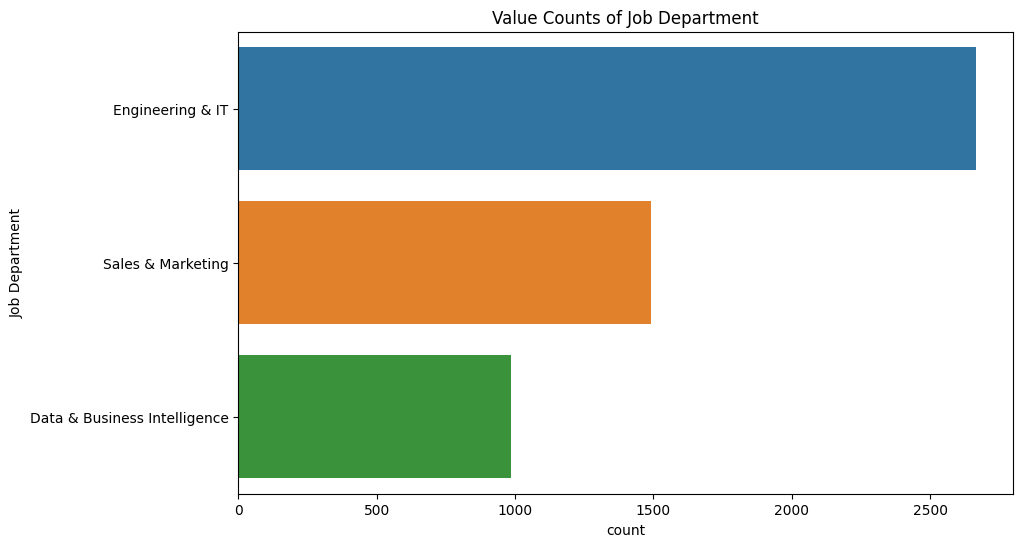

In [40]:
# Get transformed data for analysis
df_transformed = transformer.get_transformed_data()
analysis = DataAnalysis(df_transformed)
analysis.describe_data()
analysis.display_unique_values(['Education Level', 'Job Title', 'Year Hired', 'Job Department'])
analysis.plot_value_counts('Job Department')

### **STEP : 5** - Plot the time series

> #### We plot the number of fresher hires in the top three departments with the highest hiring from 1988 to 2022. The goal is to identify hiring trends across these departments within a single plot for easy comparison.

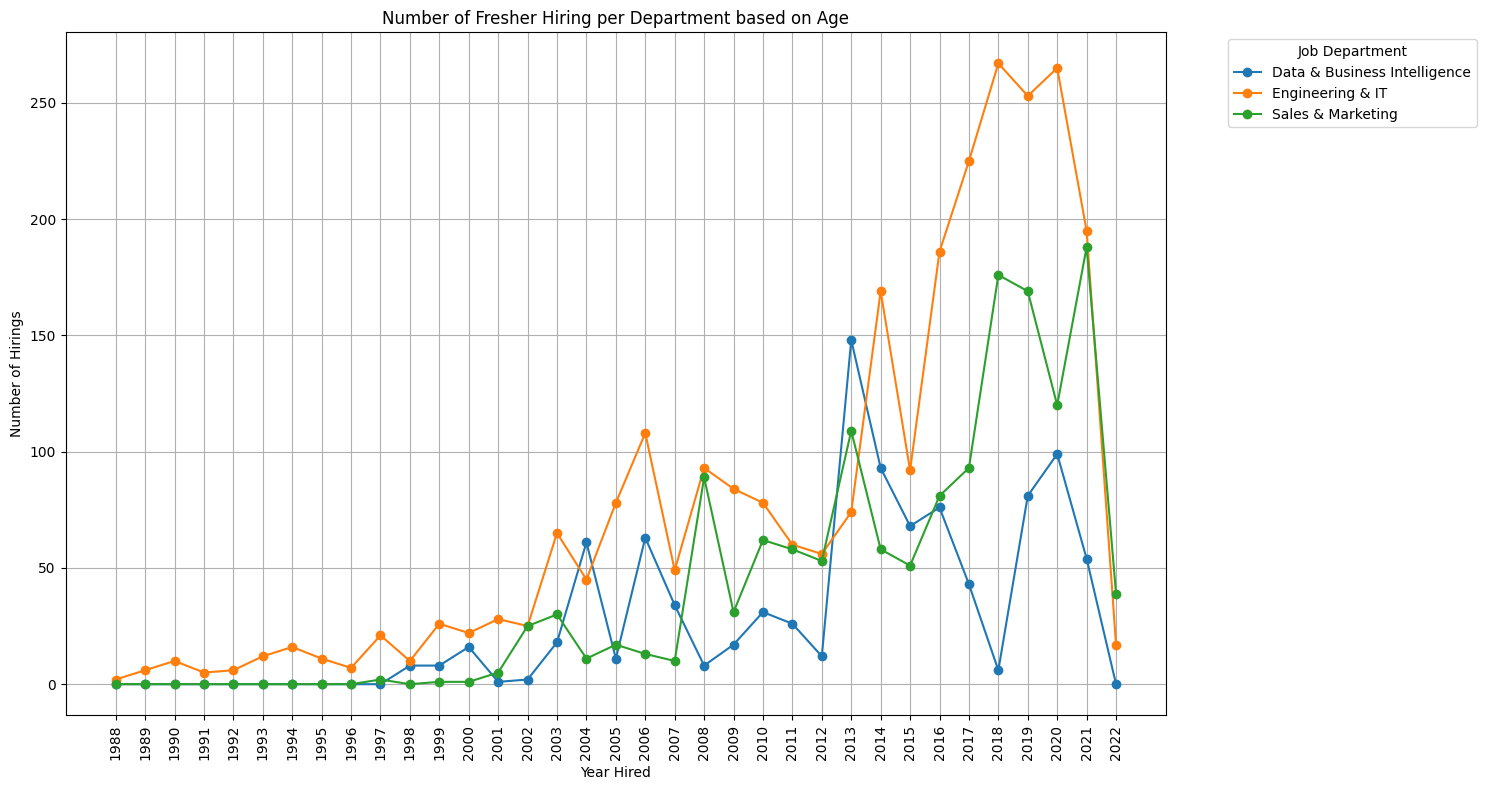

In [42]:
analysis.plot_grouped_data(
    index_col='Job Department',
    x_col='Year Hired',
    value_col='Age as Fresher',
    agg_func='count',
    title='Number of Fresher Hiring per Department based on Age',
    xlabel='Year Hired',
    ylabel='Number of Hirings'
)


> #### In this step, we identify the top three job departments with the highest number of fresher hires. A time series analysis is performed for each of these departments, plotting the hiring trends over the years while differentiating the data by gender. This analysis aims to observe patterns or fluctuations in fresher recruitment and assess the presence of any gender bias in the hiring process across these key departments.

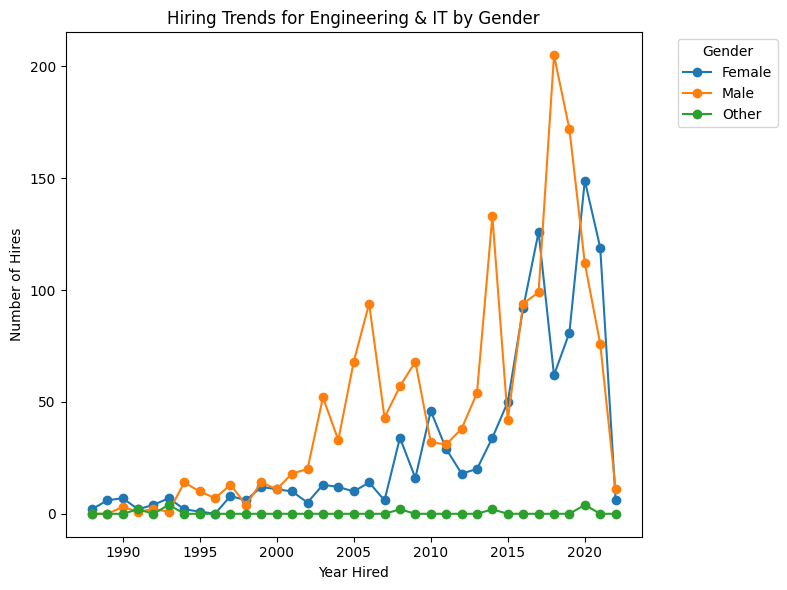

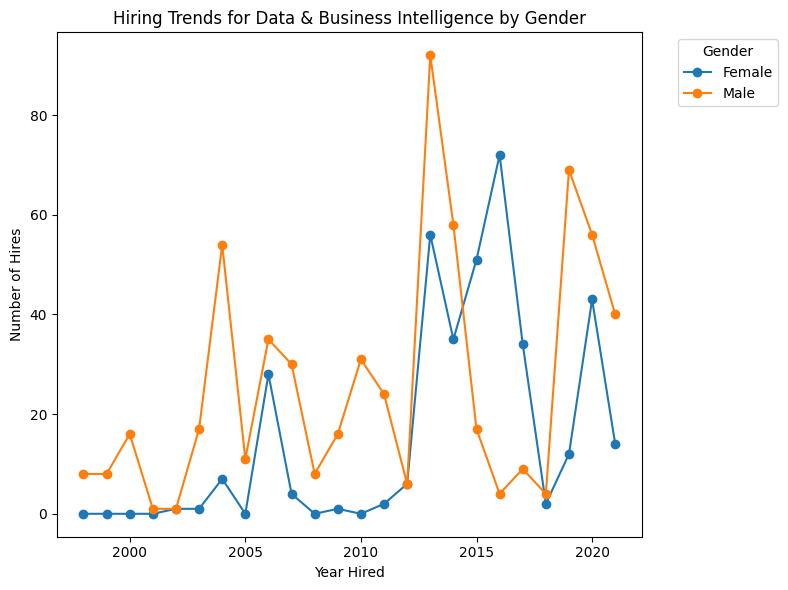

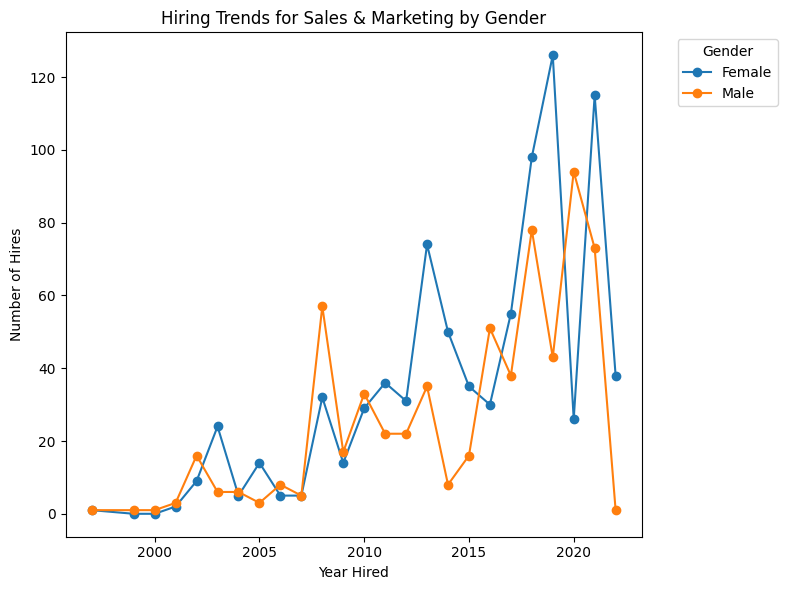

In [43]:
# Initialize the DataAnalysis object with your DataFrame
analysis = DataAnalysis(df_transformed)  # Ensure df_transformed is used

# Loop through each unique job category and call the plot function
for industry in df_transformed['Job Department'].unique():
    analysis.plot_for_category(
        category_value=industry,  # Current category value
        category_col='Job Department',  # Column to filter by
        x_col='Year Hired',  # X-axis column
        group_by_cols=['Year Hired', 'Gender'],  # Group by these columns
        title_prefix='Hiring Trends for',  # Prefix for the title
        xlabel='Year Hired', 
        ylabel='Number of Hires'  # Corrected spelling
    )


#### **Step 7**. Calculating and Plotting Moving Average

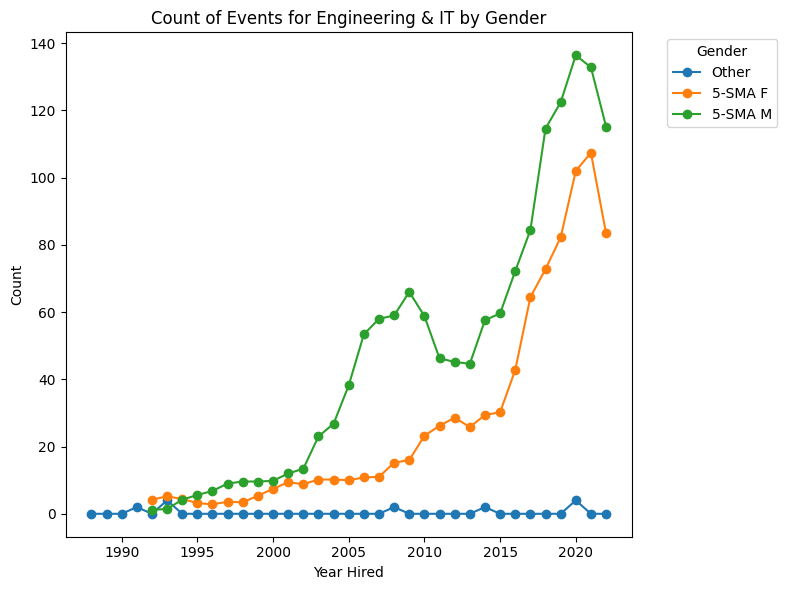

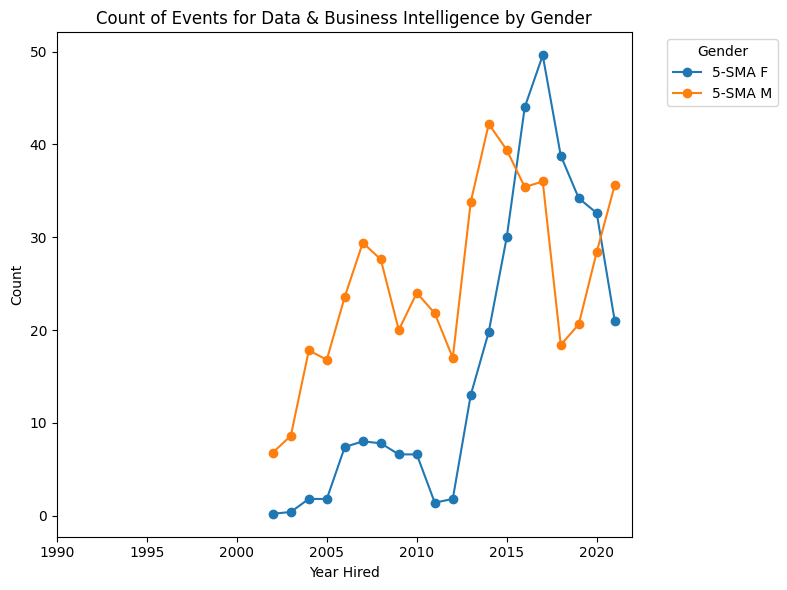

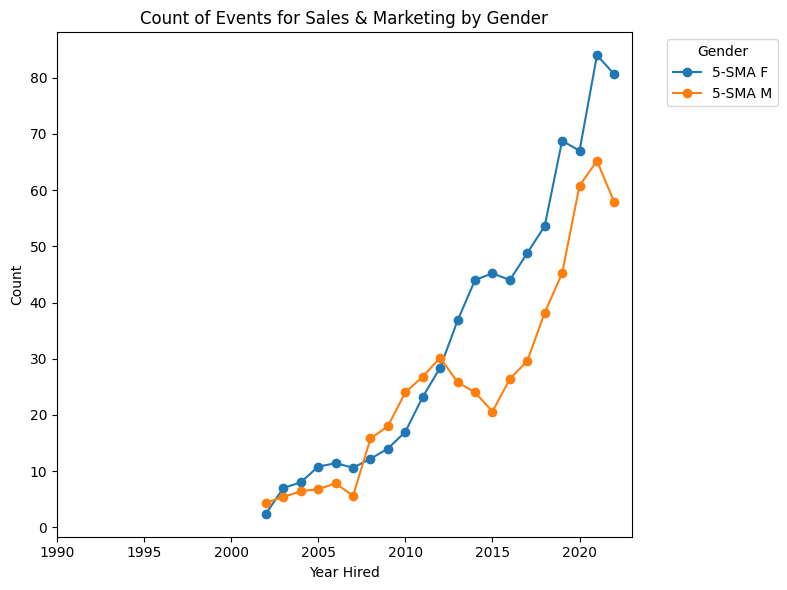

In [44]:
plot_sma_helper = MovingAveragePlotter(df_transformed)
plot_sma_helper.plot_industry_data()

#### **Summary of Time Series Exploration on the new dataset**
- For all three industries we analysed the trend suggests that for both females and males hiring of freshers is in an upward trend.
- In Engineering industry we can clearly see a bias favouring male freshers throughout the time period we could examine.
- Similarly for Sales and Marketing except for ashort time period between 2007 to 2012 female freshers are favoured over male freshers.
- For Data and Business Intelligence industry till 2015 it was in favour of male freshers but the tables turned after that in favor of female freshers.

- We could not find any seasonality in the time series.

- One thing to note here is that since the dataset was actually a snapshot representing 2022 and one thing that we can also deduce is that experienced people are more in Engineering industry which explains the series beginning from 1990's. It is also possible that in the other two industries people retire earlier.

- There time series didn't exhibit any seasonality.
- After applying log transformation also we couldn't judge if it was additive or multiplicative. It appears to be an upwards random walk.
